<a href="https://colab.research.google.com/github/geet121/Projects/blob/main/solarenergy_passion_etal_lgbm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Horizontal Photovoltaic Power Prediction for 12 Sites

### Import relevant libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from lightgbm import LGBMRegressor

#Utility library
import time
import warnings
warnings.filterwarnings("ignore")

#Parallel training
import joblib
from joblib import parallel_backend, register_parallel_backend

### Load dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Pasion et al dataset.csv')

### Explore the data

##### Identify available columns in the data

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21045 entries, 0 to 21044
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Location       21045 non-null  object 
 1   Date           21045 non-null  int64  
 2   Time           21045 non-null  int64  
 3   Latitude       21045 non-null  float64
 4   Longitude      21045 non-null  float64
 5   Altitude       21045 non-null  int64  
 6   YRMODAHRMI     21045 non-null  float64
 7   Month          21045 non-null  int64  
 8   Hour           21045 non-null  int64  
 9   Season         21045 non-null  object 
 10  Humidity       21045 non-null  float64
 11  AmbientTemp    21045 non-null  float64
 12  PolyPwr        21045 non-null  float64
 13  Wind.Speed     21045 non-null  int64  
 14  Visibility     21045 non-null  float64
 15  Pressure       21045 non-null  float64
 16  Cloud.Ceiling  21045 non-null  int64  
dtypes: float64(8), int64(7), object(2)
memory usage: 2

In [ ]:
print (type(r['Time']), type(r['Season']), type(r['Visibility']), type(r['Date']))

<class 'int'> <class 'str'> <class 'float'> <class 'int'>


In [6]:
df.head()

Location      Date  Time  Latitude  Longitude  Altitude    YRMODAHRMI  \
0  Camp Murray  20171203  1145     47.11    -122.57        84  2.017120e+11   
1  Camp Murray  20171203  1315     47.11    -122.57        84  2.017120e+11   
2  Camp Murray  20171203  1330     47.11    -122.57        84  2.017120e+11   
3  Camp Murray  20171204  1230     47.11    -122.57        84  2.017120e+11   
4  Camp Murray  20171204  1415     47.11    -122.57        84  2.017120e+11   

   Month  Hour  Season  Humidity  AmbientTemp  PolyPwr  Wind.Speed  \
0     12    11  Winter  81.71997     12.86919  2.42769           5   
1     12    13  Winter  96.64917      9.66415  2.46273           0   
2     12    13  Winter  93.61572     15.44983  4.46836           5   
3     12    12  Winter  77.21558     10.36659  1.65364           5   
4     12    14  Winter  54.80347     16.85471  6.57939           3   

   Visibility  Pressure  Cloud.Ceiling  
0        10.0    1010.6            722  
1        10.0    1011.3             23  
2        10.0    1011.6             32  
3         2.0    1024.4              6  
4         3.0    1023.7              9

##### Calculate summary statistics of numerical columns

In [7]:
df.describe()

Date          Time      Latitude     Longitude      Altitude  \
count  2.104500e+04  21045.000000  21045.000000  21045.000000  21045.000000   
mean   2.017720e+07   1267.483725     38.213823   -108.593678    798.843668   
std    4.579585e+03    167.602767      6.323761     16.364130    770.681794   
min    2.017052e+07   1000.000000     20.890000   -156.440000      1.000000   
25%    2.017111e+07   1100.000000     38.160000   -117.260000      2.000000   
50%    2.018032e+07   1300.000000     38.950000   -111.180000    458.000000   
75%    2.018062e+07   1400.000000     41.150000   -104.710000   1370.000000   
max    2.018100e+07   1545.000000     47.520000    -80.110000   1947.000000   

         YRMODAHRMI         Month          Hour      Humidity   AmbientTemp  \
count  2.104500e+04  21045.000000  21045.000000  21045.000000  21045.000000   
mean   2.017718e+11      6.565883     12.627845     37.121941     29.285117   
std    4.579846e+07      2.983958      1.672952     23.823011     12.366820   
min    2.017050e+11      1.000000     10.000000      0.000000    -19.981770   
25%    2.017110e+11      4.000000     11.000000     17.529300     21.915280   
50%    2.018030e+11      7.000000     13.000000     33.123780     30.289150   
75%    2.018060e+11      9.000000     14.000000     52.593990     37.474670   
max    2.018100e+11     12.000000     15.000000     99.987790     65.738370   

            PolyPwr    Wind.Speed    Visibility      Pressure  Cloud.Ceiling  
count  21045.000000  21045.000000  21045.000000  21045.000000   21045.000000  
mean      12.978583     10.318318      9.700071    925.944747     515.966785  
std        7.123255      6.385030      1.351949     85.215659     301.903379  
min        0.257330      0.000000      0.000000    781.700000       0.000000  
25%        6.404570      6.000000     10.000000    845.500000     140.000000  
50%       13.798700      9.000000     10.000000    961.100000     722.000000  
75%       18.863650     14.000000     10.000000   1008.900000     722.000000  
max       34.285020     49.000000     10.000000   1029.500000     722.000000

##### Visualize data distribution

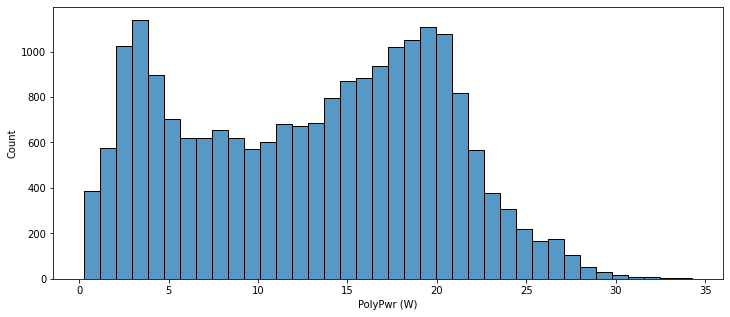

In [8]:
# Plot histogram of target variable
plt.figure(figsize=(12,5))
sns.histplot(df.PolyPwr);
plt.xlabel('PolyPwr (W)');

In [ ]:
#sns.pairplot(df)

##### Correlation analysis

In [ ]:
df_corr = df[['Location', 'Time', 'Latitude', 'Longitude', 'Altitude',
              'YRMODAHRMI', 'Month', 'Hour', 'Season', 'Humidity', 'AmbientTemp',
              'Wind.Speed', 'Visibility', 'Pressure', 'Cloud.Ceiling', 'PolyPwr']].corr()

In [ ]:
mask = np.triu(np.ones_like(df_corr, dtype=bool))

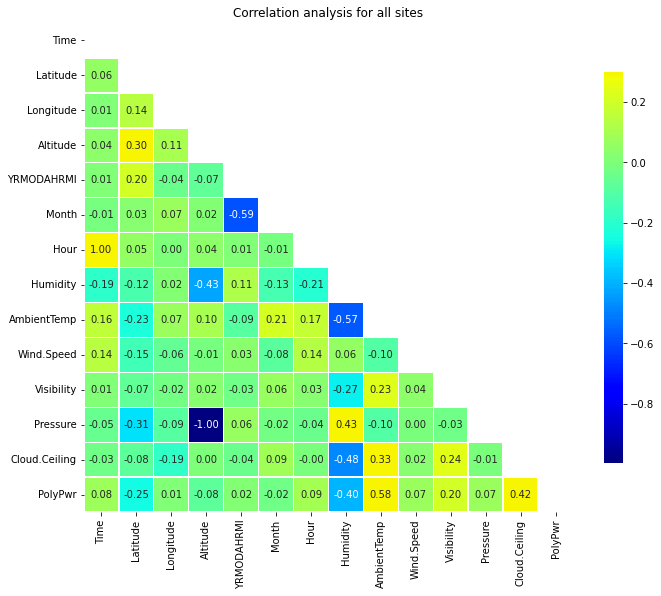

In [ ]:
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(df_corr, mask=mask, cmap='jet', vmax=.3, center=0, annot=True, fmt='.2f',
            square=True, linewidths=.5, cbar_kws={"shrink": .8});
plt.title('Correlation analysis for all sites');

### Summary of data Explorartion

<font size="3"> 1. The correlation between Ambient temperature, humidity and power improved when using site level data rather than fleet level data.<br/>
<font size="3"> 2. Also, some input features have their correlation sign with target change for individual sites compared with total sites data (e.g windspeed). <br/>
<font size="3"> 3. Hence, it may be necessary to build machine learning models per site to get the best out of the models. It might also be worth trying to encode the site-specific features like site location.<br/>
<font size="3"> 4. Altitude and pressure are perfectly correlated however, altitude does not change for a particular site and cannot be used for site-level modeling.

### Data Preprocessing

##### Check for missing values

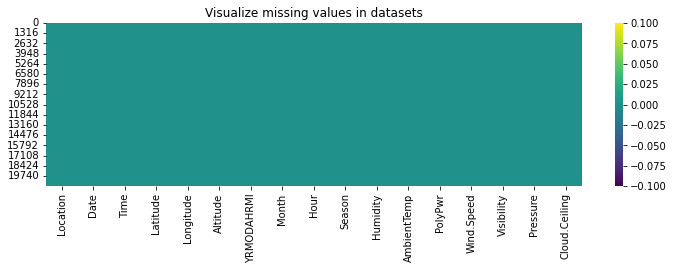

In [ ]:
plt.figure(figsize=(12, 3))
sns.heatmap(df.isnull(), cmap='viridis');
plt.title('Visualize missing values in datasets');

##### Feature Engineering

In [ ]:
# Encode location data
df_with_location_en = pd.get_dummies(df, columns=['Location'], drop_first=True)
df_with_location_en

Date  Time  Latitude  Longitude  Altitude    YRMODAHRMI  Month  \
0      20171203  1145     47.11    -122.57        84  2.017120e+11     12   
1      20171203  1315     47.11    -122.57        84  2.017120e+11     12   
2      20171203  1330     47.11    -122.57        84  2.017120e+11     12   
3      20171204  1230     47.11    -122.57        84  2.017120e+11     12   
4      20171204  1415     47.11    -122.57        84  2.017120e+11     12   
...         ...   ...       ...        ...       ...           ...    ...   
21040  20180928  1530     38.95    -104.83      1947  2.018090e+11      9   
21041  20180929  1300     38.95    -104.83      1947  2.018090e+11      9   
21042  20180929  1400     38.95    -104.83      1947  2.018090e+11      9   
21043  20180929  1500     38.95    -104.83      1947  2.018090e+11      9   
21044  20181001  1400     38.95    -104.83      1947  2.018100e+11     10   

       Hour  Season  Humidity  ...  Location_Hill Weber  Location_JDMT  \
0        11  Winter  81.71997  ...                    0              0   
1        13  Winter  96.64917  ...                    0              0   
2        13  Winter  93.61572  ...                    0              0   
3        12  Winter  77.21558  ...                    0              0   
4        14  Winter  54.80347  ...                    0              0   
...     ...     ...       ...  ...                  ...            ...   
21040    15    Fall  11.66992  ...                    0              0   
21041    13    Fall  18.22510  ...                    0              0   
21042    14    Fall  15.52124  ...                    0              0   
21043    15    Fall   6.63452  ...                    0              0   
21044    14    Fall  22.58301  ...                    0              0   

       Location_Kahului  Location_MNANG  Location_Malmstrom  \
0                     0               0                   0   
1                     0               0                   0   
2                     0               0                   0   
3                     0               0                   0   
4                     0               0                   0   
...                 ...             ...                 ...   
21040                 0               0                   0   
21041                 0               0                   0   
21042                 0               0                   0   
21043                 0               0                   0   
21044                 0               0                   0   

       Location_March AFB  Location_Offutt  Location_Peterson  \
0                       0                0                  0   
1                       0                0                  0   
2                       0                0                  0   
3                       0                0                  0   
4                       0                0                  0   
...                   ...              ...                ...   
21040                   0                0                  0   
21041                   0                0                  0   
21042                   0                0                  0   
21043                   0                0                  0   
21044                   0                0                  0   

       Location_Travis  Location_USAFA  
0                    0               0  
1                    0               0  
2                    0               0  
3                    0               0  
4                    0               0  
...                ...             ...  
21040                0               1  
21041                0               1  
21042                0               1  
21043                0               1  
21044                0               1  

[21045 rows x 27 columns]

In [ ]:
# Encode season data
df_with_loc_season_en = pd.get_dummies(df_with_location_en, columns=['Season'], drop_first=True)
df_with_loc_season_en

Date  Time  Latitude  Longitude  Altitude    YRMODAHRMI  Month  \
0      20171203  1145     47.11    -122.57        84  2.017120e+11     12   
1      20171203  1315     47.11    -122.57        84  2.017120e+11     12   
2      20171203  1330     47.11    -122.57        84  2.017120e+11     12   
3      20171204  1230     47.11    -122.57        84  2.017120e+11     12   
4      20171204  1415     47.11    -122.57        84  2.017120e+11     12   
...         ...   ...       ...        ...       ...           ...    ...   
21040  20180928  1530     38.95    -104.83      1947  2.018090e+11      9   
21041  20180929  1300     38.95    -104.83      1947  2.018090e+11      9   
21042  20180929  1400     38.95    -104.83      1947  2.018090e+11      9   
21043  20180929  1500     38.95    -104.83      1947  2.018090e+11      9   
21044  20181001  1400     38.95    -104.83      1947  2.018100e+11     10   

       Hour  Humidity  AmbientTemp  ...  Location_MNANG  Location_Malmstrom  \
0        11  81.71997     12.86919  ...               0                   0   
1        13  96.64917      9.66415  ...               0                   0   
2        13  93.61572     15.44983  ...               0                   0   
3        12  77.21558     10.36659  ...               0                   0   
4        14  54.80347     16.85471  ...               0                   0   
...     ...       ...          ...  ...             ...                 ...   
21040    15  11.66992     43.22510  ...               0                   0   
21041    13  18.22510     28.98247  ...               0                   0   
21042    14  15.52124     33.49167  ...               0                   0   
21043    15   6.63452     51.62163  ...               0                   0   
21044    14  22.58301     32.83958  ...               0                   0   

       Location_March AFB  Location_Offutt  Location_Peterson  \
0                       0                0                  0   
1                       0                0                  0   
2                       0                0                  0   
3                       0                0                  0   
4                       0                0                  0   
...                   ...              ...                ...   
21040                   0                0                  0   
21041                   0                0                  0   
21042                   0                0                  0   
21043                   0                0                  0   
21044                   0                0                  0   

       Location_Travis  Location_USAFA  Season_Spring  Season_Summer  \
0                    0               0              0              0   
1                    0               0              0              0   
2                    0               0              0              0   
3                    0               0              0              0   
4                    0               0              0              0   
...                ...             ...            ...            ...   
21040                0               1              0              0   
21041                0               1              0              0   
21042                0               1              0              0   
21043                0               1              0              0   
21044                0               1              0              0   

       Season_Winter  
0                  1  
1                  1  
2                  1  
3                  1  
4                  1  
...              ...  
21040              0  
21041              0  
21042              0  
21043              0  
21044              0  

[21045 rows x 29 columns]

In [ ]:
min_hour_of_interest = 10
max_hour_of_interest = 15

In [ ]:
df_with_loc_season_en['delta_hr']= df_with_loc_season_en.Hour - min_hour_of_interest

In [ ]:
# Create Cyclic date features
df_with_loc_season_en['sine_mon']= np.sin((df_with_loc_season_en.Month - 1)*np.pi/11)
df_with_loc_season_en['cos_mon']= np.cos((df_with_loc_season_en.Month - 1)*np.pi/11)
df_with_loc_season_en['sine_hr']= np.sin((df_with_loc_season_en.delta_hr*np.pi/(max_hour_of_interest - min_hour_of_interest)))
df_with_loc_season_en['cos_hr']= np.cos((df_with_loc_season_en.delta_hr*np.pi/(max_hour_of_interest - min_hour_of_interest)))

In [ ]:
mask2 = np.triu(np.ones_like(df_with_loc_season_en.corr(), dtype=bool))

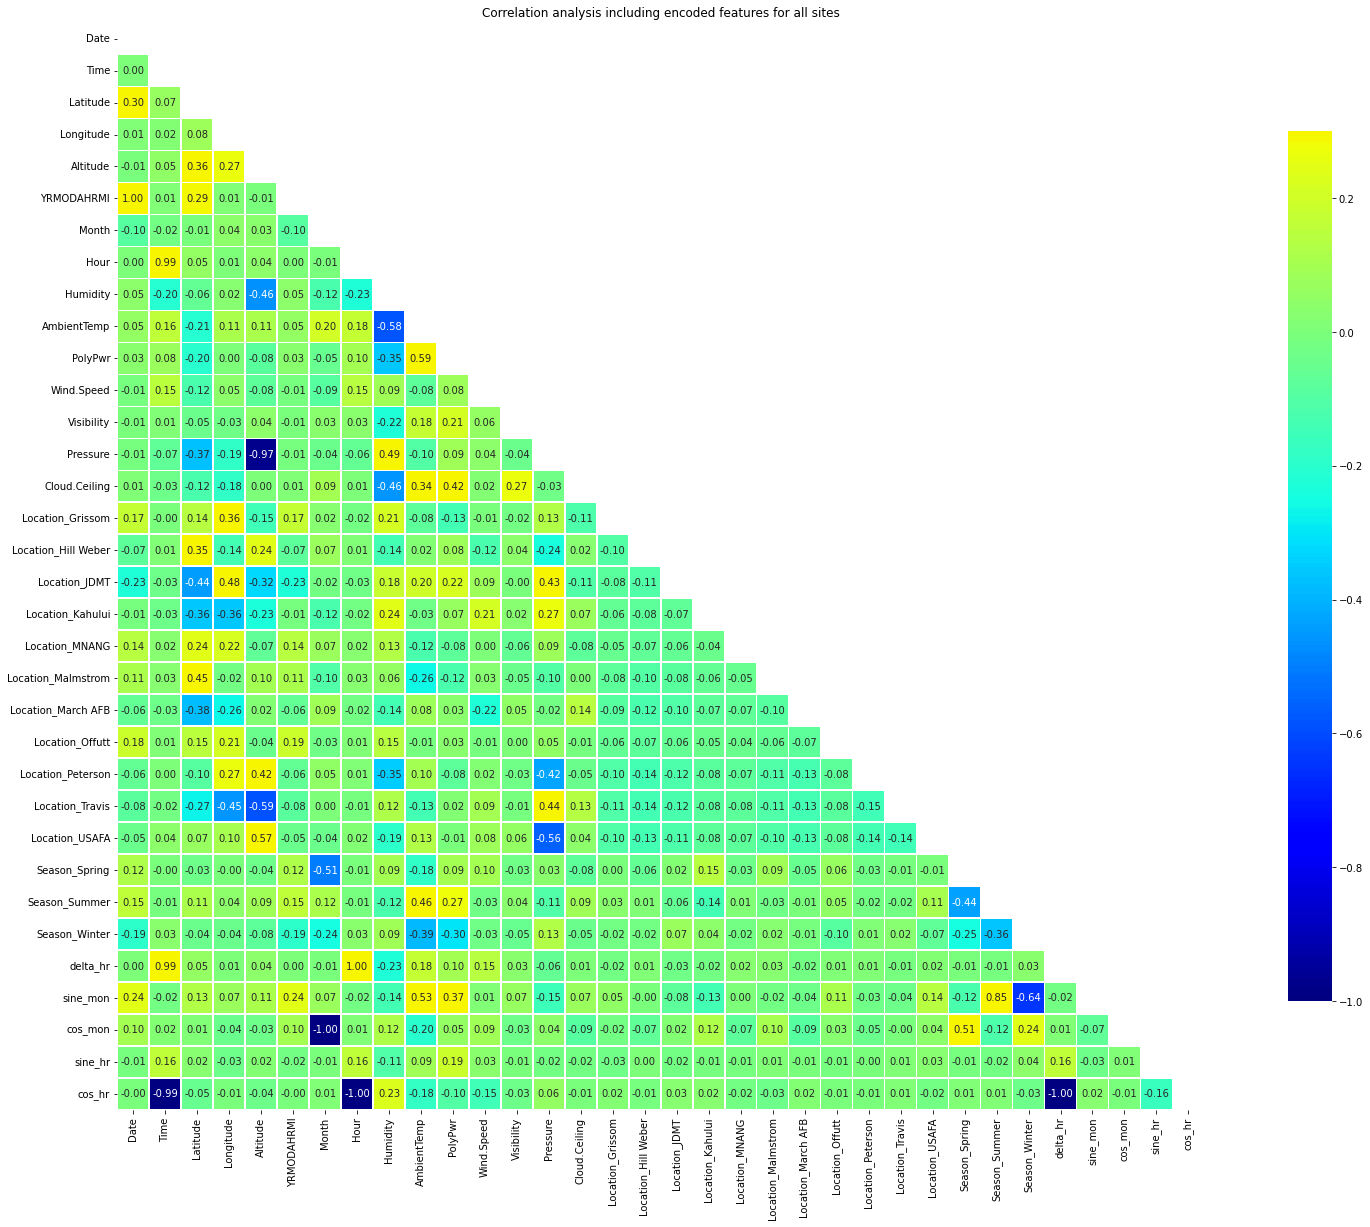

In [ ]:
f, ax = plt.subplots(figsize=(30, 20))
sns.heatmap(df_with_loc_season_en.corr(method='spearman'), mask=mask2, cmap='jet', vmax=.3, center=0, annot=True, fmt='.2f',
            square=True, linewidths=.5, cbar_kws={"shrink": .8});
plt.title('Correlation analysis including encoded features for all sites');

### Modeling

##### Feature Selection

In [ ]:
selected_columns = ['Latitude', 'Humidity', 'AmbientTemp', 'PolyPwr', 'Wind.Speed',
                     'Visibility', 'Pressure', 'Cloud.Ceiling', 'Location_Grissom',
                     'Location_Hill Weber', 'Location_JDMT', 'Location_Kahului',
                     'Location_MNANG', 'Location_Malmstrom', 'Location_March AFB',
                     'Location_Offutt', 'Location_Peterson', 'Location_Travis',
                     'Location_USAFA','Season_Spring', 'Season_Summer', 'Season_Winter',
                     'sine_mon', 'cos_mon', 'sine_hr', 'cos_hr']

In [ ]:
df_processed = df_with_loc_season_en[selected_columns].reset_index(drop=True)

In [ ]:
target_label = 'PolyPwr'

In [ ]:
input_feat = list(set(selected_columns).difference(set([target_label])))

##### Summary of feature selection

<font size="3"> 1. Altitude is dropped because it has a high correlation with Pressure but does not change for a given location while presesure is more dynamic. <br/>
<font size="3"> 2. Longitude is dropped because it has zero correlation with the target variable. <br/>
<font size="3"> 3. Time, Hour, Month and Date are dropped because they have strong correlations with the engineered cyclic features but low correlation with the target variable. 

##### Extract test set from all data

In [ ]:
df_X = df_processed[input_feat].reset_index(drop=True)

In [ ]:
df_y = df_processed[target_label]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=42)

##### Perform Cross-validation on training data for hyper-parameter tuning


In [ ]:
# Create list of each hyper-param to tune
n_estimators_list = [int(50*x) for x in range(2, 30)]

learning_rate_list = [round(x/500, 4) for x in range(2, 25)]

max_depth_list = [int(x) for x in range(3, 13)]
max_depth_list.append(-1)

n_leaves_list = [int(50*x) for x in range(2, 30)]

feature_fraction_list = [x/10 for x in range(1, 10)]

objective_list = ['rmse', 'mae', 'mape']

In [ ]:
# Structure model hyper-params as a dictionary
lgbm_grid = {'num_leaves':n_leaves_list,
             'max_depth':max_depth_list,
             'learning_rate':learning_rate_list,
             'n_estimators':n_estimators_list,
             'feature_fraction':feature_fraction_list,
             'objective':objective_list}

In [ ]:
def train_model(model,X_train, y_train, cpu_core ):
  start_time = time.time()
  model.fit(X_train, y_train)
  end_time = time.time()
  time_taken_sklearn = end_time - start_time
  print(f"Time take to train for {cpu_core} CPU core is {time_taken_sklearn}")


In [ ]:
print("\n LightGBM")
for core in [None,1,2,4,6,8,-1]:
  lgb_reg = LGBMRegressor(n_estimators=500, random_state=10, n_jobs=core)
  train_model(lgb_reg,X_train, y_train, core)


 LightGBM
Time take to train for None CPU core is 1.0905818939208984
Time take to train for 1 CPU core is 1.0247178077697754
Time take to train for 2 CPU core is 1.2248845100402832
Time take to train for 4 CPU core is 2.419318199157715
Time take to train for 6 CPU core is 3.107362985610962
Time take to train for 8 CPU core is 3.9731075763702393
Time take to train for -1 CPU core is 3.9993529319763184


##### Random search CV


##### Train model using optimal hyper-parameters

In [ ]:
lgbm_model = LGBMRegressor(objective='rmse', num_leaves=900, n_estimators=1400, max_depth=11, learning_rate=0.008, feature_fraction=0.6, random_state=42)


In [ ]:
lgbm_model.fit(X_train, y_train)

LGBMRegressor(feature_fraction=0.6, learning_rate=0.008, max_depth=11,
              n_estimators=1400, num_leaves=900, objective='rmse',
              random_state=42)

##### Make model inferences on test set

In [ ]:
y_pred = lgbm_model.predict(X_test)

##### Evaluate model performance on test set

In [ ]:
explained_variance_score(y_test.ravel(), y_pred)

0.6769725951758954

In [ ]:
#R2 corresponds to the squared correlation between the observed outcome values and the predicted values by the model. The Higher the R-squared, the better the model.
r2_score(y_test.ravel(), y_pred)

0.6769663861622941

In [ ]:
mean_absolute_error(y_test.ravel(), y_pred)

2.7207610669275013

In [ ]:
#RMSE is the average squared difference between the observed actual outome values and the values predicted by the model. 
#So, MSE = mean((observeds - predicteds)^2) and RMSE = sqrt(MSE). The lower the RMSE, the better the model.
np.sqrt(mean_squared_error(y_test.ravel(), y_pred))

4.050959334926856

In [ ]:
mean_absolute_percentage_error(y_test.ravel(), y_pred)*100

49.71319351811642

In [ ]:
def train_model_in_parallel(model,X_train, y_train, backend= 'ray' ):
  if backend == 'ray':
    register_ray()

  with joblib.parallel_backend(backend):
    start_time = time.time()
  model.fit(X_train, y_train)
  end_time = time.time()
  time_taken = end_time - start_time
  print(f"Time take to train for {backend} CPU core is {time_taken}")

In [ ]:
for backend in ['loky','threading','multiprocessing']:
  rf_reg = RandomForestRegressor(n_estimators=750, random_state=10,n_jobs=-1)
  train_model_in_parallel(rf_reg,X_train, y_train,backend=backend)

Time take to train for loky CPU core is 55.283347606658936
Time take to train for threading CPU core is 55.46113610267639
Time take to train for multiprocessing CPU core is 56.93327617645264


In [ ]:
print('Parameters currently in use:\n')
print(rf_reg.get_params())

Parameters currently in use:

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 750, 'n_jobs': -1, 'oob_score': False, 'random_state': 10, 'verbose': 0, 'warm_start': False}


In [ ]:
rf_model = RandomForestRegressor(n_estimators=250, criterion="squared_error", max_depth=11, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0, max_features="auto", n_jobs=1, random_state=10)


In [ ]:
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=11, min_weight_fraction_leaf=0,
                      n_estimators=250, n_jobs=1, random_state=10)

In [ ]:
y_predict = rf_model.predict(X_test)

In [ ]:
explained_variance_score(y_test.ravel(), y_predict)

0.6597083139111919

In [ ]:
r2_score(y_test.ravel(), y_predict)

0.6596769063069072

In [ ]:
mean_absolute_error(y_test.ravel(), y_predict)

2.8492913413377754

In [ ]:
mean_absolute_percentage_error(y_test.ravel(), y_predict)*100

51.45494248952357

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)
{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [ ]:
rf_random = RandomizedSearchCV(estimator = rf_reg, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)


In [ ]:
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=RandomForestRegressor(n_estimators=750, n_jobs=-1,
                                                   random_state=10),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [ ]:
y_pre = rf_random.predict(X_test)

In [ ]:
explained_variance_score(y_test.ravel(), y_pre)

0.669929814419967

In [ ]:
r2_score(y_test.ravel(), y_pre)

0.6699233648035638

In [ ]:
mean_absolute_error(y_test.ravel(), y_pre)

2.776304839932038

In [ ]:
mean_absolute_percentage_error(y_test.ravel(), y_predict)*100

51.45494248952357